# Linear Regression

In this notebook we'll explore how you can perform linear regression and the principles behind it. 
We'll first begin with a simple example of how one can perform linear regression through gradient descent then show how you can do an equivalent method via sklearn. Finally we'll work through cross-validation through both holdout and k-folds then explore the effect of regularization on the models we create.

***

First we'll import some Python modules that will prove useful for visualization and performing gradient descent

In [2]:
import numpy as np
from sklearn.datasets import make_regression

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Creating your dataset

In [17]:
#Make synthetic dataset for regression
n = 300
bias = 20
noise = 45
X, y, coef = make_regression(n_samples=n,n_features=1,n_informative=1,
               n_targets=1,coef=True, noise=noise,bias=bias,
                             random_state=400)
y = y.reshape(-1,1)

The first thing that one might do when working with a new dataset is to plot the data. With high dimensional datasets this becomes rather difficult to do, so alternative methods of exploration are needed but we're keeping it simple here. 

In [24]:
plt.style.use('seaborn')

[]

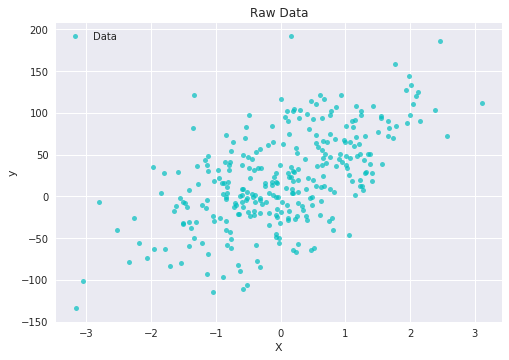

In [28]:
fig, ax = plt.subplots()

ax.plot(X,y,'c.',markersize=10,alpha=0.7,label='Data')

ax.set_xlabel('X')
ax.set_ylabel('y')
ax.set_title('Raw Data')
ax.legend()
plt.plot()

Now that we've visualized our features (which in effect, has shown us that *we can predict y from X*), we can fit a linear regression model:

In [29]:
from sklearn.linear_model import LinearRegression

With sklearn model fitting is incredibly easy to do. All you need to do is to specify a model, then fit the model to the data that you have.

In [32]:
lm = LinearRegression()
lm.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Once a model is fit we can query some properties from it such as the coefficients of the linear model and the intercept.

In [35]:
print(lm.coef_)
print(lm.intercept_)

[[31.45961436]]
[20.74127461]


You can interpret the linear model as such:

$$\hat{y} = w^Tx + \beta$$

Where:

- $w$ = <code>lm.coef_</code>
- $\beta$ = <code>lm.intercept_</code>

In order to use the model in order to predict new values, we can feed it a set of inputs to predict on using <code>lm.predict</code>:

In [40]:
predX = np.linspace(-5,5).reshape(-1,1)
predy = lm.predict(predX)

To visualize the model which is sometimes useful to do (especially in the low-dimensional case), we can generate predictions for a set of input X values and overlay the model over our raw data:

[]

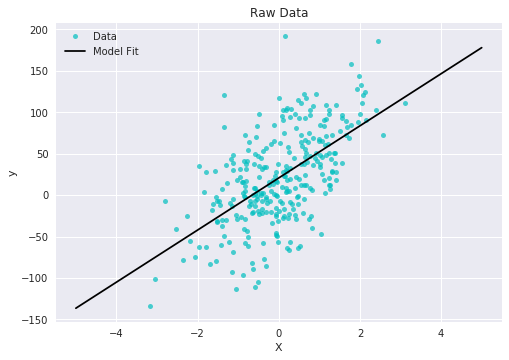

In [41]:
fig, ax = plt.subplots()

ax.plot(X,y,'c.',markersize=10,alpha=0.7,label='Data')
ax.plot(predX,predy, 'k', label='Model Fit')

ax.set_xlabel('X')
ax.set_ylabel('y')
ax.set_title('Raw Data')
ax.legend()
plt.plot()

Now that we've visualized the model we can also calculate residuals which is a way of assessing how well our model did. To do this, all we need to do is to generate predictions for each point in our raw data and then compare it to the actual datapoint of our raw data:

In [45]:
y_hat = lm.predict(X)
error = y - y_hat
mse = (error**2).sum()/y.shape[0]
print(mse)

2054.621628615472


In [48]:
lm.intercept_

array([20.74127461])

Of course the value of the MSE that we generate isn't really a useful indicator all by itself. It only really makes sense when we compare it to an alternative model. Let's suppose that we have an alternative model of the following form which we've just eye-balled:

$$f(x) = 25X + 25$$

### Exercise: 
Visualize the two linear regression models. Which one do you think is better? Calculate the MSE on the alternative model. Which model has the lower MSE? 

### Solution:

In [54]:
alt_yhat = 25 * X + 25
alt_error = y - alt_yhat
alt_mse = (alt_error**2).sum()/y.shape[0]
print('sklearn LinearModel MSE: {}'.format(mse))
print('Eye-balled LinearModel MSE: {}'.format(alt_mse))

sklearn LinearModel MSE: 2054.621628615472
Eye-balled LinearModel MSE: 2117.9277148345204


Our eye-balled linear model did surprisingly well but does not perform as well as Sklearn's optimized linear model. 

***

But wait! We just fit some ML models on our entire dataset then calculated the MSE using the data that we fit the model to! **This is wrong!!!!**. With the goal of statistical modelling being generalizability of your models, we need to re-do this, and do it properly... let's perform cross-validation to get an idea of how well our model will perform. We'll perform two types of cross-validation:

1. Holdout Cross Validation
2. K-Fold Cross validation

### Holdout Cross Validation

Let's use Pandas to simplify working with the data and keep tabs on which subset of the data is meant for training or testing:

In [80]:
df = pd.DataFrame(np.c_[X,y])
df.columns = ['X','y']

Let's perform 60/40 holdout split. That means we'll have to select 60% of our data to convert into Training and 40% of our data to convert into Testing. We'll do this by using pandas <code>DataFrame.sample</code> which will shuffle our raw data then we'll convert 60% of the data into train and 40% of the data into test:

In [112]:
#First get indices for each of the training data
train_inds = df.sample(frac=0.6, random_state=20).index
test_inds = [d for d in df.index if d not in train_inds]

In [113]:
df.head()

,X,y,holdout
0,-1.145570,-92.898458,train
1,-1.350129,82.159735,train
2,-3.164098,-133.766468,train
3,0.603344,-21.835366,test
4,-1.470409,-7.533816,test


### Exercise

Train the model on the training dataset, then compute the MSE on both the training and testing dataset

### Solution

In [126]:
train_yhat = lm.predict(df.loc[train_inds, ['X']])
train_error = df.loc[train_inds, 'y'] - train_yhat
train_mse = (train_error**2).sum()/train_error.shape[0]
print(train_mse)

y    1855.585322
dtype: float64


In [127]:
test_yhat = lm.predict(df.loc[test_inds,['X']])
test_error = df.loc[test_inds,'y'] - test_yhat
test_mse = (test_error**2).sum()/test_error.shape[0]
print(test_mse)

y    2357.719559
dtype: float64


With **holdout** in particular, there's an easier way to set up your data using sklearn which can produce train and test data for you automatically:

In [128]:
from sklearn.model_selection import train_test_split

In [132]:
train_X, train_y, test_X, test_y = train_test_split(df['X'],df['y'],test_size=0.4)

In [134]:
train_X.head()

39     0.154698
136    0.631643
87     0.577368
299   -0.294066
125    0.249228
Name: X, dtype: float64

We can proceed as usual with the same level of caution for dealing with data shapes

### Exercise:

Perform holdout cross-validation on data generated by <code>train_test_split</code>

As expected a model optimized on the training data need not perform well against testing data indicating to us our expected generalization performance is not as good as we'd expect when we trained the model on the full dataset. This is actually rather typical. However as it is a **holdout** validation score and our dataset is relatively small it's subject to error. Instead let's use a better estimate **k-fold** cross validation which is slightly more complicated to set up.

***

### K-Fold Cross Validation

Recall that **K-Fold** cross validation is done through splitting up the data into $K$ different subsets of the data. We select each subset of the data and use it as a test set, the rest of the $K-1$ folds become our training data to build a model on:

Easy steps to building a **K-Fold** cross-validation dataset:
1. Shuffle the data order to ensure randomization (in case your data is ordered for whatever reason)
2. Split the data into $K$ equal segments
3. For each segment assign it a fold number equal to which segment it is

In [138]:
#Pick number of folds
K = 5

In [156]:
#Shuffle the data
r_df = df.sample(frac=1).reset_index()

In [157]:
#Get total number of samples:
n_samples = r_df.shape[0]
seg_width = n_samples//K
seg_ranges = np.zeros( (K + 1 ))
seg_ranges[:-1] = np.arange(0,n_samples,seg_width)
seg_ranges[-1] = n_samples

In [163]:
#Loop through K times and assign each subset it's fold
for i in np.arange(0,K):
    r_df.loc[seg_ranges[i] : seg_ranges[i+1], 'fold'] = i
    
r_df['fold'] = r_df['fold'].astype(np.int)
r_df['fold'].unique()

array([0, 1, 2, 3, 4])

Now that we've assigned each subset of the data a fold number the next step is to loop through each fold, train the model on the rest of the data, and test it on the selected fold:

In [178]:
lm = LinearRegression()
errors = np.zeros(K)
for i in np.arange(0,K):
    
    test = r_df.loc[ r_df['fold'] == i, :]
    train = r_df.loc[ r_df['fold'] != i, :]
    
    
    #Fit model
    lm.fit(train[['X']],train[['y']])
    
    #Test
    yhat = lm.predict(test[['X']])
    error = test[['y']] - yhat
    mse = (error**2).sum()/test.shape[0]
    errors[i] = mse

avg_mse = errors.mean()
print(avg_mse)

2077.038272496422


K-Folds gives a much more stable estimate of what our MSE would look like on unseen data. In fact the larger K is, the more stable your estimate is (under some conditions), with a trade-off of compute time. 

***

Another easy way to calculate MSE on your data is to use <code>sklearn.metrics</code> which provides a function to easily calculate mean squared error. It looks as follows:

In [189]:
from sklearn.metrics import mean_squared_error

In [199]:
train_X, test_X, train_y, test_y = train_test_split(df['X'],df['y'],test_size=0.4)

#Convert to matrix to deal with annoying Series behaviour...
train_X = train_X.values.reshape(-1,1)
train_y = train_y.values.reshape(-1,1)
test_X = test_X.values.reshape(-1,1)
test_y = test_y.values.reshape(-1,1)

lm = LinearRegression()
lm.fit(train_X,train_y)

yhat = lm.predict(test_X)
mean_squared_error(test_y,yhat)

1850.7128178047947

***

## Expanding to multiple dimensions and regularization of your linear model


Now that we've familiarized ourselves with running a linear model in 2-dimensional space it's time to really take advantage of linear regression's ability to deal with high-dimensional space!

We'll go over the following concepts:

1. Training a high-dimensional linear regression model
2. What overfitting looks like
3. Ridge penalization
4. LASSO regression as a linear feature selector

### Make dataset

In [286]:
X, y = make_regression(n_samples=300, n_features=100, n_informative=5, n_targets=1, bias=20,
                      effective_rank=10,noise=10)

df = pd.DataFrame(np.c_[X,y])
colnames = ['x{}'.format(i) for i in np.arange(0,X.shape[1])]
colnames.append('y')
df.columns = colnames

In [287]:
df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x91,x92,x93,x94,x95,x96,x97,x98,x99,y
0,-0.016332,-0.029998,0.025692,0.036438,0.002867,-0.006458,0.009555,-0.019746,0.013447,0.015645,...,-0.016801,0.035045,-0.008503,-0.014717,-0.013745,0.007514,0.009524,-0.013257,-0.017677,5.948895
1,-0.029570,0.014569,-0.033643,-0.003181,0.005403,-0.004055,-0.060722,0.024337,0.011587,0.018878,...,0.001011,-0.008260,0.025129,0.009004,0.005713,0.004385,-0.003775,-0.002268,0.062343,25.876604
2,0.000805,0.002831,0.037743,0.045772,-0.036491,0.000221,0.006221,-0.001605,0.003920,0.032551,...,-0.008936,0.006759,0.004673,-0.048127,-0.027282,-0.019730,-0.012682,0.014421,-0.016503,24.906888
3,0.011311,0.014665,0.024365,0.024417,0.008377,0.022570,0.006968,-0.000907,-0.010709,0.020783,...,0.032635,-0.017108,0.001563,0.042633,0.020622,-0.034433,-0.036111,-0.002560,-0.017401,13.523093
4,-0.000698,-0.003809,-0.023655,-0.041255,0.051600,-0.016694,-0.053136,0.010205,0.035530,0.007630,...,-0.000900,0.043015,-0.017487,-0.018605,0.064708,-0.038424,-0.016295,-0.033151,0.016201,23.166194


With this dataset, we have $50$ features to work with, and $2000$ samples! This is effectively not visualizable and therefore will require us work with our intuition with how data behaves in high-dimensional space.

First we'll start with the most naive approach. Let's start with a simple regression model, explore where it goes wrong with K-fold cross-validation, then try other approaches that can help us get better generalization out of our data:

I've created some "helper functions" to get you set up quickly. If you'd like to know how things work feel free to copy and paste the function code and examine how each step functions to assign K folds

In [288]:
K = 10

In [289]:
#Helper function to deal with K-folds
def make_kfolds(df,K):
    
    #Make K segments to split daat into, and shuffle data up
    #Notice reset_index does not contain (drop=True)
    #The old index is saved as a column called 'index'
    #We'll use this to "unshuffle" our dataframe containing assigned K values
    shuf_df = df.sample(frac=1).reset_index()
    n_samples = shuf_df.shape[0]
    seg_width = n_samples//K
    seg_ranges = np.zeros( (K + 1 ))
    seg_ranges[:-1] = np.arange(0,n_samples,seg_width)
    seg_ranges[-1] = n_samples
    
    #Assign K to shuffled data
    for i in np.arange(0,K):
        shuf_df.loc[seg_ranges[i] : seg_ranges[i+1], 'fold'] = i
    
    #Make into integer type
    shuf_df['fold'] = shuf_df['fold'].astype(np.int)
    
    df = pd.merge(df, shuf_df [['index','fold']], how='inner', left_on=df.index, right_on='index')
    return df['fold']
    
    

In [290]:
from sklearn.metrics import mean_squared_error

In [291]:
#Assign K-folds to DataFrame
df['fold'] = make_kfolds(df,K)

In [292]:
#Perform linear modelling on each fold and calculate train vs test MSE
train_mses = np.zeros(K)
test_mses = np.zeros(K)
feature_columns = [c for c in df.columns if 'x' in c]
lm = LinearRegression()
for i in np.arange(0,K):
    
    #Pull train and test data for current fold
    train_mask = df['fold'] != i
    ktrain_X = df.loc[train_mask, feature_columns]
    ktrain_y = df.loc[train_mask, ['y']]
    
    test_mask = df['fold'] == i
    ktest_X = df.loc[test_mask, feature_columns]
    ktest_y = df.loc[test_mask, ['y']]
    
    #Train model
    lm.fit(ktrain_X,ktrain_y)
    
    #Calculate training MSE
    train_yhat = lm.predict(ktrain_X)
    train_mse = mean_squared_error(train_yhat,ktrain_y)
    train_mses[i] = train_mse
    
    #Calculate test MSE
    test_yhat = lm.predict(ktest_X)
    test_mse = mean_squared_error(test_yhat,ktest_y)
    test_mses[i] = test_mse

In [293]:
#Print train and test mses
list(zip(train_mses,test_mses))

[(67.03237052116458, 176.30801104377628),
 (71.77443753141723, 106.3245977199062),
 (62.797484609422206, 215.28269143296282),
 (67.67401310613046, 153.62602633964707),
 (59.97688307371939, 243.94325601967856),
 (68.7094812962535, 152.1827750052712),
 (65.35276375341289, 193.1185326185165),
 (67.26199300573232, 175.93922770652168),
 (71.81277959515177, 101.74122674836221),
 (72.81541441058683, 95.59608907180525)]

In [309]:
print(train_mses.mean(), test_mses.mean())
print(train_mses.std(), test_mses.std())

67.52076209029912 161.40624337064475
3.8756962828418415 47.1428172327177


Looks like our model performs a lot worse on the test set compared to our training set... The error is sometimes 3-4 times larger than what we see in the training set. This is a classic result of over-fitting your data! 

The probable reason for why this is the case is that the number of features that we have is just **way too high**. We have a tiny sample relative to the number of features that we need to deal with. This scenario is all too common in big-data derived from health-care (and usually even worse!). 

If you recall from the ML theory lecture, there are a few ways to combat this:

1. ***Stop being greedy* and pick out your important features**. However in this case we have no idea what our data actually means, it's just a bunch of $x_i$ meaningless features we have no *a priori* knowledge about. So this isn't a feasibe option...
2. **Dimensionality Reduction**. This is a great way to reduce the number of features in your dataset while maintaining as much variance as possible. We'll get to this in a later component of this workshop
3. **Regularization**. We could try using **regularization** to deal with the problem of having too many features.
***

Recall that **regularization** works by modifying the cost function such that it is penalized by the total weight of the features. There are two main kinds of regularization that are typically used (although an infinite amount of regularization methods exist!). 

1. **Ridge** - $L_2$ penalization using the form $\text{Cost} + \lambda \sum_{i=0}^{K}w_i^2$
2. **LASSO** - $L_1$ penalization using the form $\text{Cost} + \lambda \sum_{i=0}^{K}|w_i|$

We'll explore both these techniques and how they influence our ability to generalize to unseen data. 

***
Remember that $\lambda$ is a weight factor that determines just *how strongly we should penalize high feature weights*. This is called a **hyperparameter** of the model and is typically also optimized. However we won't explore this topic as that is pretty advanced. Although if you're interested look up:

1. Hyperparameter optimization
2. sklearn's GridSearchCV, RandomSearchCV
3. Bayesian Optimization of Hyperparameters
4. Nested K-fold cross validation
***

Luckily, using both **Ridge** and **LASSO** penalization for our models is as easy as importing it from <code>sklearn</code>! We train it the exact same way we do it for the standard <code>LinearRegression</code> model

In [297]:
from sklearn.linear_model import Lasso, Ridge

### Ridge-penalized Regression

Let's first train our Ridge-penalized linear model using the same K-fold cross-validation

In [374]:
ridge_train_mses = np.zeros(K)
ridge_test_mses = np.zeros(K)
feature_columns = [c for c in df.columns if 'x' in c]
rlm = Ridge(alpha=0.5)

for i in np.arange(0,K):
    
    #Pull train and test data for current fold
    train_mask = df['fold'] != i
    ktrain_X = df.loc[train_mask, feature_columns]
    ktrain_y = df.loc[train_mask, ['y']]
    
    test_mask = df['fold'] == i
    ktest_X = df.loc[test_mask, feature_columns]
    ktest_y = df.loc[test_mask, ['y']]
    
    #Train model
    rlm.fit(ktrain_X,ktrain_y)
    
    #Calculate training MSE
    train_yhat = rlm.predict(ktrain_X)
    train_mse = mean_squared_error(train_yhat,ktrain_y)
    ridge_train_mses[i] = train_mse
    
    #Calculate test MSE
    test_yhat = rlm.predict(ktest_X)
    test_mse = mean_squared_error(test_yhat,ktest_y)
    ridge_test_mses[i] = test_mse

In [375]:
print( ridge_train_mses.mean(), ridge_test_mses.mean())
print( ridge_train_mses.std(), ridge_test_mses.std())

96.73095647838252 112.08760334280817
4.135396357789876 40.525354938727695


Notice what happened here! With Ridge penalization what we did was perform a trade-off. Intuitively what's happening is that Ridge penalization reducing feature weights (linear model coefficients) across all our features which is effectively reducing the complexity of our model. Thus in total our model is being shifted from being too complex (over-fitting, too much variance) to a simpler model (slightly under-fitting possibly, less variance)!

Since our end goal really is to maximize the generalizability of our model, we've gained a net positive by penalizing our model for selecting weights that are too high!

### LASSO Regression

**LASSO** also performs a somewhat similar task to **Ridge**. If you recall from the lecture, the main difference between LASSO and Ridge is that while Ridge reduces only the overall mean weight across all features, LASSO has a tendency to push some features to 0 (features it deems "unimportant" by way of collinearity). 

The game-changing thing about **LASSO** is that it gives us a *subset of features that stand-out as being useful in predicting the outcome $y$*. This is incredibly useful for helping us narrow down on useful features when we're flooded with tons of data. In a scientific setting **LASSO** is great for data-driven hypothesis generation. 

In [380]:
lasso_train_mses = np.zeros(K)
lasso_test_mses = np.zeros(K)
feature_columns = [c for c in df.columns if 'x' in c]
llm = Lasso(alpha=0.05)

for i in np.arange(0,K):
    
    #Pull train and test data for current fold
    train_mask = df['fold'] != i
    ktrain_X = df.loc[train_mask, feature_columns]
    ktrain_y = df.loc[train_mask, ['y']]
    
    test_mask = df['fold'] == i
    ktest_X = df.loc[test_mask, feature_columns]
    ktest_y = df.loc[test_mask, ['y']]
    
    #Train model
    llm.fit(ktrain_X,ktrain_y)
    
    #Calculate training MSE
    train_yhat = llm.predict(ktrain_X)
    train_mse = mean_squared_error(train_yhat,ktrain_y)
    lasso_train_mses[i] = train_mse
    
    #Calculate test MSE
    test_yhat = llm.predict(ktest_X)
    test_mse = mean_squared_error(test_yhat,ktest_y)
    lasso_test_mses[i] = test_mse

In [381]:
print( lasso_train_mses.mean(), lasso_test_mses.mean())
print( lasso_train_mses.std(), lasso_test_mses.std())

109.88424079460438 111.88569036663105
4.4071686224144795 39.72881975540047


LASSO performs almost as well as Ridge on the training dataset, but more importantly it also selects a subset of useful features. Let's take a look at the feature weights determined by each of the models that we've trained. For the final model remember that we train the model on the full dataset so let's do that:

In [382]:
lm = LinearRegression()
lm.fit(df[feature_columns],df['y'])

rlm = Ridge(alpha=0.5)
rlm.fit(df[feature_columns],df['y'])

llm = Lasso(alpha=0.05)
llm.fit(df[feature_columns],df['y'])

Lasso(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

With each model trained let's pull out the coefficient each model spits out. We'll include the intercepts as well:

In [383]:
lm_coeff = np.r_[ np.array(lm.intercept_), lm.coef_ ]
rlm_coeff = np.r_[ np.array(rlm.intercept_), rlm.coef_ ]
llm_coeff = np.r_[ np.array(llm.intercept_), llm.coef_ ]

Now with every coefficient pulled out, let's plot them all:

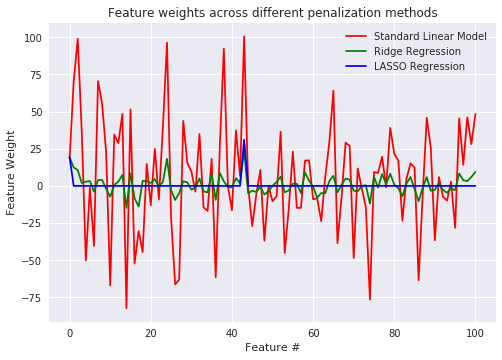

In [386]:
fig, ax = plt.subplots()
x = np.arange(0,lm_coeff.shape[0])
ax.plot(x,lm_coeff,'r',label='Standard Linear Model')
ax.plot(x,rlm_coeff,'g',label='Ridge Regression')
ax.plot(x,llm_coeff,'b',label='LASSO Regression')

ax.set_xlabel('Feature #')
ax.set_ylabel('Feature Weight')
ax.set_title('Feature weights across different penalization methods')
ax.legend()
plt.show()